In [1]:
import os
import sys

try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))  
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils_elicitation import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

# !pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic_pair import Heuristic5
from pct.tree.heuristic.NumericHeuristic_pair import NumericHeuristic5
from pct.tree.splitter.splitter_yahoo import Splitter
from pct.tree.Yahootree import Tree

In [3]:
filtered_df = pd.read_csv("../Yahoodata/filtered_semi_binary.csv")
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0.00,artist,238709,0
1,9,169510,0.00,artist,169510,0
2,9,208084,1.00,artist,208084,0
3,9,245398,0.00,artist,245398,0
4,9,153166,0.00,artist,153166,0
...,...,...,...,...,...,...
1524889,248947,83754,0.01,artist,83754,0
1524890,248947,141799,0.00,genre,0,[141799]
1524891,248947,141677,0.00,artist,141677,0
1524892,248947,262458,0.00,artist,262458,0


In [4]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))

In [5]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [6]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

In [7]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold

In [8]:
def data_builder(seed, warm_ratio=0.1, strategy="artist-only"):
    """
    说明：
    - fixed horiztonal split_users_by_ratio：warm/cold ）
    - randomness from K/X/T 的 np.random.choice（ np.random.seed(seed)）

    return：
    dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )
    """
    import random
    import numpy as np

    # 1) Python random and NumPy random
    random.seed(seed)
    np.random.seed(seed)

    # 2) warm/cold split
    all_user_ids = sorted(filtered_df['user_id'].unique().tolist())
    warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, warm_ratio)

    # 3) global warm and cold dataframe
    global df_warm, df_cold
    df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
    df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

    # 4) matrix and mapping
    matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
        df_warm, "user_id", "item_id", "rating"
    )
    matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")

    # 5) K/X/T split (randomness)
    K_cold, X_cold, T_cold = split_and_combine(strategy)

    # 6) return
    return dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )


In [9]:
# 1) two different seeds
out1 = data_builder(seed=7,  strategy="artist-only")
out2 = data_builder(seed=11, strategy="artist-only")

# 2) check warm/cold consistency（fixed aplit）
assert out1["warm_users"] == out2["warm_users"], "Warm split changed unexpectedly!"
assert out1["cold_users"] == out2["cold_users"], "Cold split changed unexpectedly!"

# 3) check if X / K / T change with seed set
#   check differnce in sparsity matrix
diff_X_nnz = (out1["X"] - out2["X"]).nnz
diff_K_nnz = (out1["train"] - out2["train"]).nnz
diff_T_nnz = (out1["test"] - out2["test"]).nnz
print("Δnnz(X)=", diff_X_nnz, "Δnnz(K)=", diff_K_nnz, "Δnnz(T)=", diff_T_nnz)

# 4) difference >0
assert (diff_X_nnz + diff_T_nnz) > 0, "K/X/T did not change across seeds as expected."


Δnnz(X)= 39948 Δnnz(K)= 1357 Δnnz(T)= 38739


In [10]:
def elicitation_by_pairwise_tree_retrain_skiped(
    Tree, train, test, X, matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5, strategy=1,
    svd_random_state=None  # ← new parmeter：SVD random seed set
):
    """
    Pairwise tree-based elicitation (skip asked pairs). Retrain tree each round.
    At each iteration, select first unasked (itemA, itemB) pair and move both ratings from X to K.

    Parameters:
    - strategy: 1 (top2), 2 (most similar), 3 (least similar)

    Returns:
    - rmse_list, mae_list: performance metrics per iteration
    - item_type_stats: per-round asked item type counts
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    asked_pairs = {u: set() for u in range(num_users)}
    item_type_stats = defaultdict(lambda: defaultdict(int))
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(0, 1))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    # --- new：initialize SVD by random seed---
    algo = SVD(random_state=svd_random_state)
    # -------------------------------------------------
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked pairs, walk from root)")
        # Step 1: Retrain tree
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i+1, min_instances=5, item_type_map=item_type_map)
        pct.fit(x_df, x_df, strategy=strategy)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root
            while node and not node.is_leaf and node.attribute_name:
                itemA, itemB = node.attribute_name
                if itemA not in cid_to_idx or itemB not in cid_to_idx:
                    node = None
                    break

                itemA_idx = cid_to_idx[itemA]
                itemB_idx = cid_to_idx[itemB]
                pair = frozenset([itemA_idx, itemB_idx])

                if pair in asked_pairs[u]:
                    ratingA = train_copy[u, itemA_idx]
                    ratingB = train_copy[u, itemB_idx]
                    if ratingA > ratingB:
                        node = node.children[0]
                    elif ratingB > ratingA:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked pair found
                ratingA = X_copy[u, itemA_idx]
                ratingB = X_copy[u, itemB_idx]

                if ratingA > 0:
                    train_copy[u, itemA_idx] = ratingA
                    X_copy[u, itemA_idx] = 0
                if ratingB > 0:
                    train_copy[u, itemB_idx] = ratingB
                    X_copy[u, itemB_idx] = 0

                asked_pairs[u].add(pair)

                # 🌟 Record item type (based on itemA)
                item_type = get_item_type(itemA)
                item_type_stats[i][item_type] += 1

                break  # only one pair per user per iteration

        # Step 2: Evaluate
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        # --- new：evauate SVD by same random seed---
        algo = SVD(random_state=svd_random_state)
        # -------------------------------------------------------------
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


In [11]:

def run_many_times_single_strategy(
    Tree,
    seeds,                 # e.g., [101,102,103,104,105]  -> R=5
    iteration=2,           # per time run iterations（keep baseline -> max curve lenghth=iteration+1）
    strategy=2,            # 1=top2, 2=most-similar, 3=least-similar
    mode="hybrid"          # hybrid
):
    """
    return:
      curves: np.ndarray, shape=(R, iteration+1)
              eveay row is a curve，including baseline
    """
    curves = []
    for sd in seeds:
        # 1) construct run data this iteration（K/X/T controled by seed）
        data = data_builder(seed=sd, strategy=mode)
        # 2)  elicitation（SVD by seed）
        rmse_list, _, _ = elicitation_by_pairwise_tree_retrain_skiped(
            Tree,
            data["train"], data["test"], data["X"], data["matrix_warm"],
            data["idx_to_rid_cold"], data["idx_to_rid_warm"], data["idx_to_cid"],
            iteration=iteration, strategy=strategy,
            svd_random_state=sd
        )
        curves.append(rmse_list)  # 长度 = iteration+1
    return np.stack(curves, axis=0)  # (R, iteration+1)


# —— average + min–max interval ——
def plot_mean_with_range_single(
    curves,                 # (R, T+1)，含 baseline
    title="Pairwise (single strategy)",
    label="Strategy"
):
    R, L = curves.shape
    T = L - 1  # iterations
    x = np.arange(0, L)  # from 0 baseline

    mean_curve = curves.mean(axis=0)
    lo = curves.min(axis=0)
    hi = curves.max(axis=0)

    plt.figure(figsize=(7,5))
    plt.plot(x, mean_curve, label=f"{label} (mean)")
    plt.fill_between(x, lo, hi, alpha=0.2, label="min–max range")
    plt.xticks(x, [f"{i}" for i in x])  # show 0,1,...,T；0 is baseline
    plt.xlabel("Iteration (0 = baseline)")
    plt.ylabel("RMSE")
    plt.title(f"{title} (R={R}) — Mean with min–max bands")
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5639
MAE:  0.4115
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 195412, 151565


🔍 Pair found: 83754, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5529
MAE:  0.4117
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 195282, 199204


🔍 Pair found: 33269, 113759


🔍 Pair found: 151565, 195412


🔍 Pair found: 278591, 151565


🔍 Pair found: 189015, 206831


🔍 Pair found: 83754, 278591


🔍 Pair found: 293719, 58658


🔍 Pair found: 128993, 141075


🔍 Pair found: 189015, 31321


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5342
MAE:  0.4107
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 243350, 166257


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 51633


🔍 Pair found: 281536, 251343


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 195412, 91211


🔍 Pair found: 142360, 270238


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5279
MAE:  0.4101
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 243350, 166257


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 257965


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 195412, 91211


🔍 Pair found: 266966, 142360


🔍 Pair found: 278591, 90230


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5217
MAE:  0.4101
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 243350


🔍 Pair found: 47482, 180868


🔍 Pair found: 47482, 180868


🔍 Pair found: 280892, 223811


🔍 Pair found: 223811, 214565


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 121457, 125200


🔍 Pair found: 278591, 121457


🔍 Pair found: 278591, 121457


🔍 Pair found: 278591, 121457


🔍 Pair found: 189015, 278591


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 195412, 91211


🔍 Pair found: 244384, 191351


🔍 Pair found: 266966, 142360


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 153166


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 286202


🔍 Pair found: 58658, 293719


🔍 Pair found: 135958, 83754


🔍 Pair found: 211701, 289463


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4086
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 243350


🔍 Pair found: 47482, 180868


🔍 Pair found: 47482, 180868


🔍 Pair found: 47482, 180868


🔍 Pair found: 280892, 257019


🔍 Pair found: 166257, 223811


🔍 Pair found: 223811, 214565


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 125200, 189015


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 91211


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 61547


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 286202


🔍 Pair found: 201697, 127541


🔍 Pair found: 58658, 293719


🔍 Pair found: 189015, 82110


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 83754


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4096
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 180868, 47482


🔍 Pair found: 157419, 112400


🔍 Pair found: 257019, 172223


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 38205


🔍 Pair found: 172223, 257019


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 125200, 189015


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 91211


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 61547


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 151565, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 286202


🔍 Pair found: 201697, 127541


🔍 Pair found: 35779, 293719


🔍 Pair found: 58658, 293719


🔍 Pair found: 189015, 82110


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 830, 83754


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4089
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 89460, 141852


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 286202


🔍 Pair found: 201697, 127541


🔍 Pair found: 35779, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 82110, 58658


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5189
MAE:  0.4099
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 47482


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 257019, 172223


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 180868


🔍 Pair found: 189272, 187696


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 107179, 201697


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 222730


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5187
MAE:  0.4099
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 47482


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 257019, 172223


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 180868


🔍 Pair found: 189272, 187696


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 201697, 107179


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 222730


🔍 Pair found: 83754, 234926


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5180
MAE:  0.4099
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 47482


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 257019, 172223


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 150050


🔍 Pair found: 189272, 180868


🔍 Pair found: 189272, 187696


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5180
MAE:  0.4099
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 112400, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 189272, 180868


🔍 Pair found: 189272, 187696


🔍 Pair found: 189272, 258848


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 172223, 257019


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 232859


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 280892


🔍 Pair found: 112400, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 189272, 281785


🔍 Pair found: 172223, 189272


🔍 Pair found: 257019, 180868


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 33269, 89460


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 89460, 33269


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 257019, 280892


🔍 Pair found: 195282, 252460


🔍 Pair found: 172223, 132285


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 132285, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 63881


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 83754


🔍 Pair found: 201697, 293719


🔍 Pair found: 201697, 35779


🔍 Pair found: 58658, 127541


🔍 Pair found: 82110, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 135958, 127541


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 64052


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 90763


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 1842, 46196


🔍 Pair found: 189015, 1842


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 1842, 46196


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5177
MAE:  0.4096
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5683
MAE:  0.4130
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 195412, 151565


🔍 Pair found: 83754, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5549
MAE:  0.4115
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 195282, 199204


🔍 Pair found: 33269, 113759


🔍 Pair found: 195412, 151565


🔍 Pair found: 278591, 151565


🔍 Pair found: 189015, 206831


🔍 Pair found: 83754, 278591


🔍 Pair found: 293719, 58658


🔍 Pair found: 128993, 141075


🔍 Pair found: 189015, 31321


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5353
MAE:  0.4101
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 251343, 281536


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 151565, 91211


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5295
MAE:  0.4100
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 176963


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 257965


🔍 Pair found: 232894, 257965


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5233
MAE:  0.4089
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 175309, 201811


🔍 Pair found: 33269, 172223


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 251338, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 211082, 59956


🔍 Pair found: 211082, 59956


🔍 Pair found: 211082, 59956


🔍 Pair found: 209104, 61547


🔍 Pair found: 278591, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 270238, 91211


🔍 Pair found: 287417, 102643


🔍 Pair found: 266966, 228732


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 58658, 194018


🔍 Pair found: 135958, 83754


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5215
MAE:  0.4085
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 251338, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 35454


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5207
MAE:  0.4082
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 251338, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 35454


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5204
MAE:  0.4082
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5201
MAE:  0.4082
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 79693


🔍 Pair found: 112039, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5201
MAE:  0.4082
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 112039


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5201
MAE:  0.4082
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 19861


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 112039


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4081
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 166257


🔍 Pair found: 189272, 172223


🔍 Pair found: 250752, 107804


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 189272, 172223


🔍 Pair found: 107804, 189272


🔍 Pair found: 247092, 107804


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 107804, 247092


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 132285


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 39427


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 218424, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 257965, 33269


🔍 Pair found: 172223, 278921


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 211082


🔍 Pair found: 197089, 251338


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 151565


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 83754


🔍 Pair found: 112039, 58658


🔍 Pair found: 79693, 238709


🔍 Pair found: 58658, 57377


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 135958, 102851


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 188567


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 273574


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5195
MAE:  0.4078
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5799
MAE:  0.4091
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5640
MAE:  0.4115
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 195412, 151565


🔍 Pair found: 83754, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5511
MAE:  0.4102
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 210805


🔍 Pair found: 195282, 199204


🔍 Pair found: 33269, 113759


🔍 Pair found: 151565, 195412


🔍 Pair found: 151565, 278591


🔍 Pair found: 189015, 206831


🔍 Pair found: 83754, 278591


🔍 Pair found: 293719, 58658


🔍 Pair found: 128993, 141075


🔍 Pair found: 189015, 31321


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5308
MAE:  0.4103
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 187609, 131753


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 135492, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 77880, 178994


🔍 Pair found: 151565, 278591


🔍 Pair found: 195412, 91211


🔍 Pair found: 142360, 270238


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5255
MAE:  0.4103
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 132285, 189272


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 257965


🔍 Pair found: 89460, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5197
MAE:  0.4091
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 114039


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 18131


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 175309, 201811


🔍 Pair found: 33269, 172223


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 109987, 132285


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 127274


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 238709, 169510


🔍 Pair found: 293719, 219924


🔍 Pair found: 135958, 83754


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 189015, 149094


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5176
MAE:  0.4088
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 131504


🔍 Pair found: 91679, 165176


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 109987, 132285


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 58658


🔍 Pair found: 76503, 293719


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5175
MAE:  0.4085
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 58658


🔍 Pair found: 76503, 293719


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 3296, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 293719


🔍 Pair found: 58658, 83754


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5171
MAE:  0.4088
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 248231, 88548


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 3296, 830


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5163
MAE:  0.4085
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 17678


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5163
MAE:  0.4085
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 17678


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5169
MAE:  0.4092
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 18131


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 58658, 279057


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 247092


🔍 Pair found: 189272, 117066


🔍 Pair found: 189272, 21644


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 112354, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 212235, 218424


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 201811, 175309


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 211476, 88548


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 88548, 211476


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 195412, 91211


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 76503


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 76503


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 83754, 58658


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 76503, 135958


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 58658, 211701


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 830


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 58658, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 58658, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 145033


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5173
MAE:  0.4095
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5823
MAE:  0.4116
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5641
MAE:  0.4122
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 195412, 151565


🔍 Pair found: 83754, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5523
MAE:  0.4116
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 150050, 210805


🔍 Pair found: 195282, 199204


🔍 Pair found: 33269, 113759


🔍 Pair found: 195412, 151565


🔍 Pair found: 151565, 278591


🔍 Pair found: 189015, 206831


🔍 Pair found: 83754, 278591


🔍 Pair found: 293719, 58658


🔍 Pair found: 128993, 141075


🔍 Pair found: 189015, 31321


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5321
MAE:  0.4099
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 187609, 131753


🔍 Pair found: 195282, 199204


🔍 Pair found: 251343, 281536


🔍 Pair found: 200000, 166141


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 209104, 91211


🔍 Pair found: 151565, 91211


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5270
MAE:  0.4102
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 19753


🔍 Pair found: 189272, 70391


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 214565


🔍 Pair found: 33269, 172223


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 257965, 236794


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 91211, 195412


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5224
MAE:  0.4094
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 19753


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 18131


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 275908, 172579


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 22913


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 281785


🔍 Pair found: 236794, 281785


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 151565


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 197089, 211082


🔍 Pair found: 91211, 195412


🔍 Pair found: 273574, 266966


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 166619


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 293719


🔍 Pair found: 293719, 189015


🔍 Pair found: 135958, 83754


🔍 Pair found: 211701, 289463


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 102299, 204824


🔍 Pair found: 189015, 149094


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5200
MAE:  0.4094
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 131504


🔍 Pair found: 91679, 165176


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 132285, 22913


🔍 Pair found: 266954, 61339


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 270715


🔍 Pair found: 211082, 197089


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 209104, 61547


🔍 Pair found: 209104, 61547


🔍 Pair found: 209104, 61547


🔍 Pair found: 209104, 61547


🔍 Pair found: 209104, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5186
MAE:  0.4094
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 830, 83754


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5182
MAE:  0.4092
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 257717


🔍 Pair found: 221102, 141866


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5186
MAE:  0.4096
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 17678


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 238709, 169510


🔍 Pair found: 58658, 257717


🔍 Pair found: 221102, 141866


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 189015


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5186
MAE:  0.4095
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 48050, 262382


🔍 Pair found: 91679, 17678


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5184
MAE:  0.4093
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 18131


🔍 Pair found: 91679, 165176


🔍 Pair found: 107804, 191690


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 210805, 150050


🔍 Pair found: 172223, 210805


🔍 Pair found: 189272, 70443


🔍 Pair found: 189272, 70391


🔍 Pair found: 189272, 291792


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 187609, 131753


🔍 Pair found: 155700, 48050


🔍 Pair found: 18131, 48050


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 165176, 17678


🔍 Pair found: 195282, 199204


🔍 Pair found: 281536, 251343


🔍 Pair found: 172223, 132285


🔍 Pair found: 212235, 166141


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 214565, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172579, 275908


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 70850, 172223


🔍 Pair found: 266954, 109987


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 109987, 266954


🔍 Pair found: 208084, 169510


🔍 Pair found: 238709, 132285


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 236794, 249824


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 211082, 59956


🔍 Pair found: 189015, 278591


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 211082, 151565


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 151565, 278591


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 79867, 293278


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 151565, 61547


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 141866


🔍 Pair found: 83754, 135958


🔍 Pair found: 221102, 226862


🔍 Pair found: 238709, 58658


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 135958, 141866


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 15676


🔍 Pair found: 83754, 216612


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 58658


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 257965


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 83754, 293719


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 155767


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 226368


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 293278, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5183
MAE:  0.4092
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5837
MAE:  0.4123
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5673
MAE:  0.4144
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 132285, 189272


🔍 Pair found: 195412, 151565


🔍 Pair found: 83754, 278591


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5541
MAE:  0.4129
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 33269, 113759


🔍 Pair found: 195412, 151565


🔍 Pair found: 151565, 278591


🔍 Pair found: 189015, 206831


🔍 Pair found: 83754, 278591


🔍 Pair found: 293719, 58658


🔍 Pair found: 128993, 141075


🔍 Pair found: 189015, 31321


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5359
MAE:  0.4128
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 172223, 64052


🔍 Pair found: 251343, 281536


🔍 Pair found: 254013, 189015


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 232894


🔍 Pair found: 257965, 211082


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 209104, 91211


🔍 Pair found: 151565, 91211


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5298
MAE:  0.4120
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 226368


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 154230, 257965


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 79867, 121457


🔍 Pair found: 209104, 91211


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 211701, 289463


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5249
MAE:  0.4122
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 189272, 226368


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 175309, 201811


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 238709, 169510


🔍 Pair found: 132285, 222730


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 121457, 125200


🔍 Pair found: 278591, 121457


🔍 Pair found: 278591, 121457


🔍 Pair found: 278591, 121457


🔍 Pair found: 189015, 278591


🔍 Pair found: 151565, 208467


🔍 Pair found: 238709, 169510


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 61547


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 270238, 91211


🔍 Pair found: 287417, 102643


🔍 Pair found: 266966, 228732


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 83754


🔍 Pair found: 58658, 293719


🔍 Pair found: 29616, 293719


🔍 Pair found: 135958, 83754


🔍 Pair found: 211701, 289463


🔍 Pair found: 830, 216612


🔍 Pair found: 83754, 58658


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5216
MAE:  0.4113
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 238709, 169510


🔍 Pair found: 132285, 59956


🔍 Pair found: 132285, 222730


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 87833, 113291


🔍 Pair found: 87833, 113291


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 1589, 211783


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 168338


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5203
MAE:  0.4117
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 87833, 113291


🔍 Pair found: 87833, 113291


🔍 Pair found: 87833, 113291


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 204824, 189015


🔍 Pair found: 1589, 211783


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 204824


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4112
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 113291, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5197
MAE:  0.4112
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5197
MAE:  0.4112
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 278591


🔍 Pair found: 189272, 132285


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 172223


🔍 Pair found: 189272, 51359


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 172223, 22697


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 22697, 269664


🔍 Pair found: 195282, 199204


🔍 Pair found: 64052, 172223


🔍 Pair found: 281536, 251343


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 132285, 281536


🔍 Pair found: 189015, 254013


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 199204, 195282


🔍 Pair found: 33269, 113759


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 154230


🔍 Pair found: 33269, 257965


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 257965, 33269


🔍 Pair found: 33269, 201811


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 201811, 33269


🔍 Pair found: 33269, 257965


🔍 Pair found: 33269, 172223


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 172223, 33269


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 201811


🔍 Pair found: 257965, 211082


🔍 Pair found: 70850, 109987


🔍 Pair found: 172223, 70850


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 132285, 189272


🔍 Pair found: 222273, 287719


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 287719, 222273


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 172223, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 109987, 70850


🔍 Pair found: 189015, 195412


🔍 Pair found: 125200, 121457


🔍 Pair found: 189015, 125200


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 172223, 252795


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 189015, 125200


🔍 Pair found: 278591, 189015


🔍 Pair found: 79867, 121457


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 278591, 189015


🔍 Pair found: 209104, 91211


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 278591, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 91211, 209104


🔍 Pair found: 83754, 189015


🔍 Pair found: 135958, 289463


🔍 Pair found: 113291, 135958


🔍 Pair found: 135958, 83754


🔍 Pair found: 293719, 231352


🔍 Pair found: 238709, 169510


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 83754


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 135958, 113291


🔍 Pair found: 211701, 289463


🔍 Pair found: 211701, 58658


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 83754


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 216612, 3296


🔍 Pair found: 1589, 293278


🔍 Pair found: 204824, 102299


🔍 Pair found: 1589, 204824


🔍 Pair found: 189015, 180182


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 204824, 1589


🔍 Pair found: 189015, 149094


🔍 Pair found: 1589, 189015


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 1589


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 189015, 293278


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 293278, 1589


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


🔍 Pair found: 189015, 83754


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5198
MAE:  0.4111
✅ Iteration 20 complete.


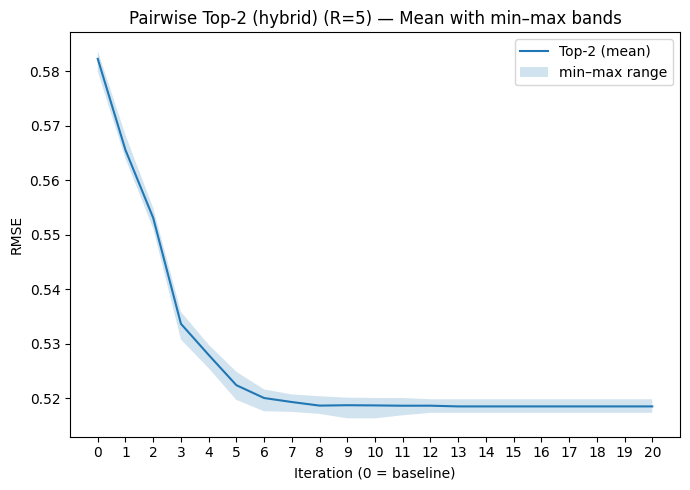

In [12]:
seeds = [101,102,103,104,105]  # R=5
T = 20                          # run iterations per time


curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
# curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
# curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
# plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
# plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")
